# test3DAlignmentbyBlock.ipynb

The aim is to prototype the xyz block alignment of fiducial marks


In [2]:
#%% imports

import numpy as np
import matplotlib.pylab as plt

from skimage import io
import os
import numpy as np
import matplotlib.pylab as plt
from imageProcessing.imageProcessing import _reinterpolatesFocalPlane, imageShowWithValues, imageShowWithValuesSingle
# from astropy.stats import SigmaClip
from scipy.stats import sigmaclip
from skimage.util.shape import view_as_blocks

from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as shiftImage
from tqdm import trange


In [3]:
#%%    - load test 3D fiducial files


rootFolder = "/home/marcnol/data/Embryo_debug_dataset/Experiment_18"
files=["scan_001_RT27_001_ROI_converted_decon_ch00.tif","scan_001_RT29_001_ROI_converted_decon_ch00.tif"]
#files=["scan_001_RT27_001_ROI_converted_decon_ch00.tif","scan_001_RT41_001_ROI_converted_decon_ch00.tif"]

filenames = [rootFolder+os.sep+x for x in files]

print("\nReading files: \n{}".format(" \n\n ".join(filenames)))
images = [io.imread(x).squeeze() for x in filenames]


Reading files: 
/home/marcnol/data/Embryo_debug_dataset/Experiment_18/scan_001_RT27_001_ROI_converted_decon_ch00.tif 

 /home/marcnol/data/Embryo_debug_dataset/Experiment_18/scan_001_RT29_001_ROI_converted_decon_ch00.tif


In [4]:
#%% simulate alignment in XY

images= [x/x.max() for x in images]

images_2D = [np.sum(x,axis=0) for x in images]

print("Calculating shifts...")
upsample_factor=100
shift, error, diffphase = phase_cross_correlation(images_2D[0], images_2D[1], upsample_factor=upsample_factor)
print("shifts = {}".format(shift))

images_2D.append(shiftImage(images_2D[1], shift))
print("ready")

Calculating shifts...
shifts = [ 0.35 -2.82]
ready


In [5]:
#%% reinterpolate second file in XY using dictionnary to get rough alignment

# this will only be done in the real pyHiM script. For now this has been simulated in the block above

shift3D = np.zeros((3))
shift3D[0],shift3D[1],shift3D[2] = 0,shift[0],shift[1]

print("Shifting image ...")
images.append(shiftImage(images[1], shift3D))
print("ready")

Shifting image ...
ready


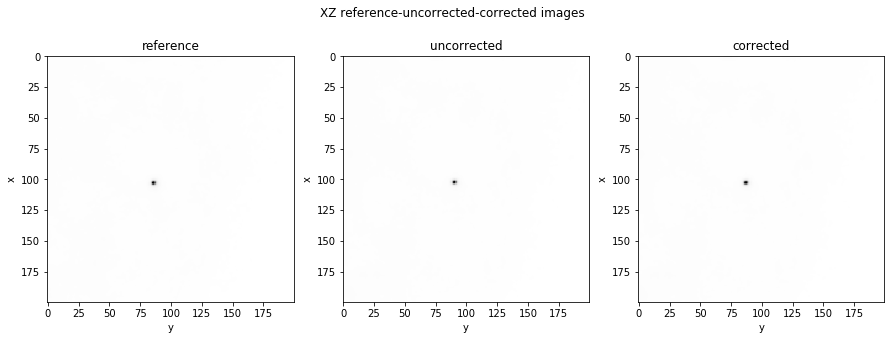

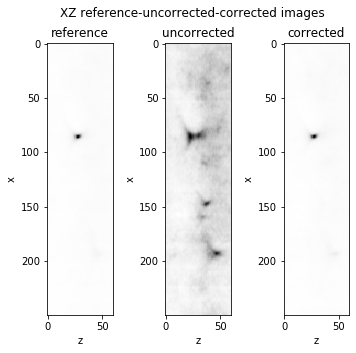

ready


In [6]:
## %% shows images so far

# XY
fig, axes = plt.subplots(1,len(images))
fig.set_size_inches((len(images)*5, 5))
ax=axes.ravel()

titles = ["reference", "uncorrected","corrected"]
fig.suptitle("XZ {} images".format("-".join(titles)))

subVolume=((0,60),(0,2048),(0,2048))
subVolume=((42,60),(1000,1200),(1200,1400))

cmap='Greys'

for axis, img, title in zip(ax,images,titles):
    axis.imshow(img[subVolume[0][0],subVolume[1][0]:subVolume[1][1],subVolume[2][0]:subVolume[2][1]],cmap=cmap,vmax=.5)
#    axis.imshow(np.sum(img[subVolume[0][0]:subVolume[0][1],subVolume[1][0]:subVolume[1][1],subVolume[2][0]:subVolume[2][1]],axis=0),cmap=cmap,vmax=1)

    axis.set_title(title)
    axis.set_xlabel('y')
    axis.set_ylabel('x')
plt.show()

# XZ
fig2, axes = plt.subplots(1,len(images))
fig2.set_size_inches((len(images)*2, 5))
ax2=axes.ravel()
fig2.suptitle("XZ {} images".format("-".join(titles)))

subVolume=((0,60),(1000,1250),(1200,1000))

for axis, img, title in zip(ax2,images,titles):
    axis.imshow(img[subVolume[0][0]:subVolume[0][1],subVolume[1][0]:subVolume[1][1],subVolume[2][0]].transpose(),cmap=cmap)

    axis.set_title(title)
    axis.set_xlabel('z')
    axis.set_ylabel('x')
plt.show()
print("ready")

In [7]:
#%% - break in blocks
blockSizeXY = 128
blockSize = (60, blockSizeXY,blockSizeXY)
upsample_factor=100

blocks=[view_as_blocks(x,block_shape = blockSize).squeeze() for x in images]

block_ref=blocks[0]
block_target=blocks[2]
print("ready")

ready


In [ ]:
#%% - loop thru blocks and do:

shiftMatrices = [np.zeros(block_ref.shape[0:2]) for x in range(3)]
# zShiftMatrix, xyShiftMatrix = np.zeros(block_ref.shape[0:2]), np.zeros(block_ref.shape[0:2])

for i in trange(block_ref.shape[0]):
    for j in range(block_ref.shape[1]):
        # - cross correlate in 3D to find 3D shift
        shifts_xyz, _, _= phase_cross_correlation(block_ref[i,j], block_target[i,j], upsample_factor=upsample_factor)
        for matrix, _shift in zip(shiftMatrices,shifts_xyz):
            matrix[i,j]= _shift
print("ready")

 44%|████▍     | 7/16 [00:22<00:30,  3.42s/it]

In [ ]:
#%% checks by plotting results
fontsize=8
cbar_kw={}
cbar_kw["fraction"]=0.046
cbar_kw["pad"]=0.04

fig, axes = plt.subplots(1,len(shiftMatrices))
fig.set_size_inches((len(shiftMatrices)*5, 5))
ax=axes.ravel()
titles = ['z shift matrix','x shift matrix','y shift matrix']
# fig.suptitle("XZ {} images".format("-".join(titles)))

for axis,title,x in zip(ax,titles,shiftMatrices):

    imageShowWithValuesSingle(axis,x,title,fontsize,cbar_kw,valfmt="{x:.1f}",cmap='YlGn') # YlGnBu
    axis.set_title(title)

